In [1]:
# !pip install tensorflow
import os
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.image import imread
from PIL import Image
import tensorflow as tf
tf.config.run_functions_eagerly(True)
import tensorflow as tf
tf.__version__

from tensorflow.keras.layers import Dense,Dropout,Input,MaxPooling2D,ZeroPadding2D,Conv2D,Flatten,GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import Adam,SGD
from tensorflow.keras.preprocessing.image import img_to_array,load_img,ImageDataGenerator
from tensorflow.keras.utils import to_categorical

2025-09-07 15:17:17.541053: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1757258237.876106      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1757258237.976198      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
img_size = (224, 224)
batch_size = 32
train_ds = tf.keras.utils.image_dataset_from_directory(
    "/kaggle/input/stanford-dogs-dataset/images/Images",
    labels = "inferred",
    label_mode="categorical",
    validation_split=0.2,   # 20% pour validation
    subset="training",
    seed=42,
    image_size=img_size,
    batch_size=batch_size
)
val_ds = tf.keras.utils.image_dataset_from_directory(
    "/kaggle/input/stanford-dogs-dataset/images/Images",
    labels="inferred",
    label_mode="categorical",
    validation_split=0.2,
    subset="validation",
    seed=42,
    image_size=img_size,
    batch_size=batch_size
)
class_names = train_ds.class_names
num_classes = len(class_names)

Found 20580 files belonging to 120 classes.
Using 16464 files for training.


I0000 00:00:1757258283.771780      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1757258283.772563      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5
/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Found 20580 files belonging to 120 classes.
Using 4116 files for validation.


In [3]:
from tensorflow.keras import layers

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),     # Ajoute le flip horizontal
    layers.RandomRotation(0.2),                       # Rotation plus large
    layers.RandomZoom(0.2),                           # Zoom plus agressif
    layers.RandomContrast(0.2),                       # Varie le contraste
    layers.RandomBrightness(0.2),                     # Varie la luminosité
    layers.RandomTranslation(height_factor=0.1, width_factor=0.1),  # Décale l’image                 
])


AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.map(lambda x, y: (data_augmentation(x)/255.0, y), num_parallel_calls=AUTOTUNE)
val_ds   = val_ds.map(lambda x, y: (x/255.0, y), num_parallel_calls=AUTOTUNE)

train_ds = train_ds.prefetch(AUTOTUNE)
val_ds   = val_ds.prefetch(AUTOTUNE)

In [14]:
from tensorflow.keras import layers, models
input_shape = (224, 224, 3)
# CNN from scratch optimisé
def build_cnn(input_shape=input_shape, num_classes=num_classes):
    inputs = layers.Input(shape=input_shape)

    # Bloc 1
    x = layers.Conv2D(32, (3,3), padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D((2,2))(x)
    x = layers.Dropout(0.2)(x)

    # Bloc 2
    x = layers.Conv2D(64, (3,3), padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D((2,2))(x)
    x = layers.Dropout(0.25)(x)

    # Bloc 3
    x = layers.Conv2D(128, (3,3), padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv2D(128, (3,3), padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D((2,2))(x)
    x = layers.Dropout(0.3)(x)

    # Bloc 4
    x = layers.Conv2D(256, (3,3), padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv2D(256, (3,3), padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D((2,2))(x)
    x = layers.Dropout(0.35)(x)

    # Classification head
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(512, activation="relu")(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(256, activation="relu")(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)

    model = models.Model(inputs, outputs, name="dog_cnn_improved")
    return model
model = build_cnn_improved() 
model.summary()
    
   

Model: "dog_cnn_improved"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_24 (Conv2D)              │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_24          │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_24 (ReLU)                 │ (None, 224, 224, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_24 (Dropout)            │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_25          │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_25 (ReLU)                 │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_25 (Dropout)            │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_26 (Conv2D)              │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_26          │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_26 (ReLU)                 │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_27 (Conv2D)              │ (None, 56, 56, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_27          │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_27 (ReLU)                 │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_26 (Dropout)            │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_28 (Conv2D)              │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_28          │ (None, 28, 28, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_28 (ReLU)                 │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 1,423,288 (5.43 MB)

 Trainable params: 1,421,560 (5.42 MB)

 Non-trainable params: 1,728 (6.75 KB)

model.summary()

In [7]:
model.summary()

Model: "dog_cnn_improved"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_24 (Conv2D)              │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_24          │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_24 (ReLU)                 │ (None, 224, 224, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_24 (Dropout)            │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_25          │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_25 (ReLU)                 │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_25 (Dropout)            │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_26 (Conv2D)              │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_26          │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_26 (ReLU)                 │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_27 (Conv2D)              │ (None, 56, 56, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_27          │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_27 (ReLU)                 │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_26 (Dropout)            │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_28 (Conv2D)              │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_28          │ (None, 28, 28, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_28 (ReLU)                 │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 1,423,290 (5.43 MB)

 Trainable params: 1,421,560 (5.42 MB)

 Non-trainable params: 1,728 (6.75 KB)

 Optimizer params: 2 (12.00 B)

In [5]:
print(num_classes)

120


In [57]:
from tensorflow.keras import optimizers, callbacks

initial_lr = 1e-3
optimizer = optimizers.Adam(learning_rate=initial_lr)

# callbacks
early_stop = callbacks.EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True
)

reduce_lr = callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,
    patience=3,
    min_lr=1e-6,
    verbose = 1
)


In [58]:
from tensorflow.keras.models import load_model

model = load_model('best_model.h5')

In [59]:
loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.05)
model.compile(
    optimizer=optimizer,
    loss= loss,
    metrics=["accuracy", tf.keras.metrics.TopKCategoricalAccuracy(k=5)]
)


In [60]:
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath='best_model.h5',
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

In [61]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    initial_epoch=127,  # ← set to the last epoch you completed
    epochs=140,         # ← total number of epochs you want to reach
    callbacks=[early_stop, reduce_lr,checkpoint],
    verbose = 1
)

Epoch 128/140
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 373ms/step - accuracy: 0.2920 - loss: 2.9570 - top_k_categorical_accuracy: 0.6452
Epoch 128: val_loss improved from inf to 3.50272, saving model to best_model.h5
515/515 ━━━━━━━━━━━━━━━━━━━━ 201s 388ms/step - accuracy: 0.2920 - loss: 2.9570 - top_k_categorical_accuracy: 0.6452 - val_accuracy: 0.2085 - val_loss: 3.5027 - val_top_k_categorical_accuracy: 0.5051 - learning_rate: 0.0010
Epoch 129/140
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step - accuracy: 0.2857 - loss: 2.9509 - top_k_categorical_accuracy: 0.6424
Epoch 129: val_loss improved from 3.50272 to 3.30970, saving model to best_model.h5
515/515 ━━━━━━━━━━━━━━━━━━━━ 200s 386ms/step - accuracy: 0.2857 - loss: 2.9509 - top_k_categorical_accuracy: 0.6424 - val_accuracy: 0.2306 - val_loss: 3.3097 - val_top_k_categorical_accuracy: 0.5459 - learning_rate: 0.0010
Epoch 130/140
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step - accuracy: 0.2933 - loss: 2.9502 - top_k_categorical_accuracy: 0.6432
Epoch 

In [21]:
# 7. Boucle d'entraînement
epochs = 20  # raisonnable
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)


Epoch 1/20
515/515 ━━━━━━━━━━━━━━━━━━━━ 109s 211ms/step - accuracy: 0.0944 - loss: 4.0028 - top_k_categorical_accuracy: 0.3379 - val_accuracy: 0.0792 - val_loss: 4.1556 - val_top_k_categorical_accuracy: 0.2894 - learning_rate: 0.0010
Epoch 2/20
515/515 ━━━━━━━━━━━━━━━━━━━━ 106s 204ms/step - accuracy: 0.0989 - loss: 4.0005 - top_k_categorical_accuracy: 0.3401 - val_accuracy: 0.0576 - val_loss: 4.3178 - val_top_k_categorical_accuracy: 0.2184 - learning_rate: 0.0010
Epoch 3/20
515/515 ━━━━━━━━━━━━━━━━━━━━ 107s 206ms/step - accuracy: 0.0985 - loss: 3.9977 - top_k_categorical_accuracy: 0.3420 - val_accuracy: 0.1013 - val_loss: 4.0074 - val_top_k_categorical_accuracy: 0.3307 - learning_rate: 0.0010
Epoch 4/20
515/515 ━━━━━━━━━━━━━━━━━━━━ 105s 203ms/step - accuracy: 0.0985 - loss: 3.9675 - top_k_categorical_accuracy: 0.3485 - val_accuracy: 0.1042 - val_loss: 4.0271 - val_top_k_categorical_accuracy: 0.3248 - learning_rate: 0.0010
Epoch 5/20
515/515 ━━━━━━━━━━━━━━━━━━━━ 106s 204ms/step - accura

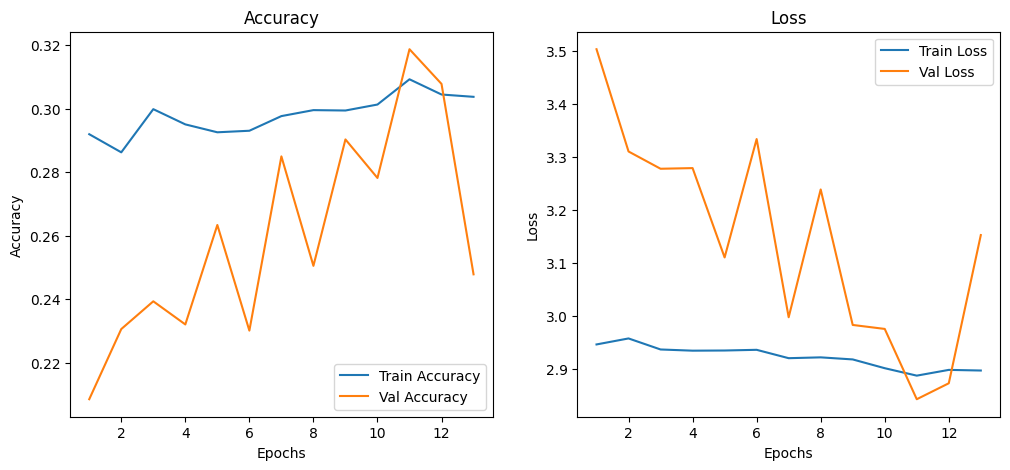

In [62]:
import matplotlib.pyplot as plt

def plot_training_curves(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(1, len(acc)+1)

    plt.figure(figsize=(12, 5))

    # Courbes d'accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Train Accuracy')
    plt.plot(epochs_range, val_acc, label='Val Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.title('Accuracy')

    # Courbes de loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Train Loss')
    plt.plot(epochs_range, val_loss, label='Val Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    plt.title('Loss')

    plt.show()

plot_training_curves(history)


In [55]:

model.save('dog_model_epoch127.h5')



In [ ]:
import pickle

with open('history.pkl', 'wb') as f:
    pickle.dump(history.history, f)
download('history.pkl')

In [ ]:
# model45=Sequential()

# model45.add(ZeroPadding2D((1,1),input_shape=(224,244,3)))
# model45.add(Conv2D(32,kernel_size=(3,3),activation='relu'))
# model45.add(ZeroPadding2D(padding=(1,1)))
# model45.add(Conv2D(32,kernel_size=(3,3),activation='relu'))
# model45.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))

# # Bloc 2 — on augmente la capacité
# x = layers.Conv2D(64, (3,3), padding="same")(x)
# x = layers.BatchNormalization()(x)
# x = layers.ReLU()(x)
# x = layers.MaxPooling2D((2,2))(x)

# # Bloc 3 — double convolution + moins de dropout
# x = layers.Conv2D(128, (3,3), padding="same", kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
# x = layers.BatchNormalization()(x)
# x = layers.ReLU()(x)
# x = layers.Conv2D(128, (3,3), padding="same", kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
# x = layers.BatchNormalization()(x)
# x = layers.ReLU()(x)
# x = layers.MaxPooling2D((2,2))(x)
# x = layers.SpatialDropout2D(0.3)(x)

# # Bloc 4 — plus profond
# x = layers.Conv2D(256, (3,3), padding="same")(x)
# x = layers.BatchNormalization()(x)
# x = layers.ReLU()(x)
# x = layers.Conv2D(256, (3,3), padding="same")(x)
# x = layers.BatchNormalization()(x)
# x = layers.ReLU()(x)
# x = layers.MaxPooling2D((2,2))(x)
# x = layers.SpatialDropout2D(0.3)(x)

# model45.add(GlobalAveragePooling2D())
# model45.add(Dense(512, activation='relu'))
# model45.add(Dropout(0.2))

# model45.add(Dense(120,activation='softmax'))

# model45.compile(loss=categorical_crossentropy,optimizer='adam',metrics=['accuracy'])
# model45.summary()

In [ ]:
# history=model45.fit(train_ds,
#                       # steps_per_epoch = 16,
#                       validation_data = val_ds,
#                       # validation_steps = 4,
#                       epochs = 2,
#                       # verbose = 1)